In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Visualising data

In [3]:
df=pd.read_csv('ml-latest-small/ratings.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [5]:

# Specify the correct file paths for each dataset
ratings_path = r'C:\Users\hp\OneDrive\Desktop\Recommendor System\ml-latest-small\ratings.csv'
movies_path = r'C:\Users\hp\OneDrive\Desktop\Recommendor System\ml-latest-small\movies.csv'

# Read the data into DataFrames
ratings_df = pd.read_csv(ratings_path, sep='::', engine='python')
movies_df = pd.read_csv(movies_path, sep=',', names=['MovieID', 'Title', 'Genres'], skiprows=1, engine='python')

# Convert 'MovieID' column to numeric
movies_df['MovieID'] = pd.to_numeric(movies_df['MovieID'])

# Display the first few rows of each DataFrame to verify
print("Ratings DataFrame:")
print(ratings_df.head())

print("\nMovies DataFrame:")
print(movies_df.head())




Ratings DataFrame:
  userId,movieId,rating,timestamp
0               1,1,4.0,964982703
1               1,3,4.0,964981247
2               1,6,4.0,964982224
3              1,47,5.0,964983815
4              1,50,5.0,964982931

Movies DataFrame:
   MovieID                               Title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        Genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


# Constuctor function

In [6]:
class MovieDataset():
    def __init__(self,users,movies,ratings):
        self.users=users
        self.movies=movies
        self.ratings=ratings
        
    def __len__(self):
        return len(self.users)
    
    def __getitem__(self,item):
        users=self.users[item]
        movies=self.movies[item]
        ratings=self.ratings[item]
        
        return{
            "users":torch.tensor(users,dtype=torch.long),
            "movies":torch.tensor(movies,dtype=torch.long),
            "ratings":torch.tensor(ratings,dtype=torch.float)
        }
        

# Simple NN

In [7]:
class RecSysModel(nn.Module):
    def __init__(self,n_users, n_movies):
        super().__init__()
        self.n_movies = n_movies 
        self.users_embed=nn.Embedding(n_users, 32)
        self.movie_embed=nn.Embedding(n_movies, 32)
        #user,movies embedding concat
        self.out=nn.Linear(64,1)
        
    def forward(self,users,movies,ratings=None):
        user_embeds=self.users_embed(users)
        movie_embeds=self.movie_embed(movies)
        output=torch.cat([user_embeds,movie_embeds],dim=1)
        
        output=self.out(output)
        
        return output
    
    def recommend_movies(self, user_id, rated_movies, movie_info_df, top_n=15):
        available_movie_ids = set(movie_info_df['MovieID'].tolist())

        # Filter rated_movies to include only those present in movie_info_df
        rated_movies = [movie_id for movie_id in rated_movies if movie_id in available_movie_ids]

        if not rated_movies:
            print(f"No rated movies found for user {user_id}.")
            return []

        # Filter unrated_movies to include only those present in the model's embedding layer
        unrated_movies = list(set(available_movie_ids) - set(rated_movies))

        if not unrated_movies:
            print(f"No unrated movies found for user {user_id}.")
            return []

        # Filter unrated_movies to include only those present in the model's embedding layer
        valid_unrated_movies = [movie_id for movie_id in unrated_movies if movie_id < self.n_movies]

        if not valid_unrated_movies:
            print(f"No valid unrated movies found for user {user_id}.")
            return []

        user_ids = torch.full((len(valid_unrated_movies),), user_id, dtype=torch.long).to(device)

        # Forward pass to get predicted ratings for unrated movies
        predicted_ratings = self.forward(user_ids, torch.tensor(valid_unrated_movies, dtype=torch.long).to(device)).squeeze()

        # Sort movie indices by predicted ratings in descending order
        sorted_indices = torch.argsort(predicted_ratings, descending=True)

        # Extract the top N movie indices
        top_n_indices = sorted_indices[:top_n]

        # Get movie information for the recommended movies
        recommended_movies_info = []
        for idx in top_n_indices:
            movie_id = valid_unrated_movies[idx]
            movie_info = movie_info_df[movie_info_df['MovieID'] == movie_id]

            if not movie_info.empty:
                movie_info_dict = {
                    'MovieID': movie_id,
                    'Title': movie_info['Title'].values[0],
                    'Genres': movie_info['Genres'].values[0],
                    # Add more columns as needed
                }
                recommended_movies_info.append(movie_info_dict)

        return recommended_movies_info

        


# Deeper NN

In [8]:
import torch.nn.functional as F

class ImprovedRecSysModel(nn.Module):
    def __init__(self, n_users, n_movies, embedding_size=32, hidden_size=64, dropout_prob=0.5):
        super(ImprovedRecSysModel, self).__init__()

        self.users_embed = nn.Embedding(n_users, embedding_size)
        self.movie_embed = nn.Embedding(n_movies, embedding_size)
        self.n_movies=n_movies
        
        self.batch_norm = nn.BatchNorm1d(2 * embedding_size)

        self.linear1 = nn.Linear(2 * embedding_size, hidden_size)
        self.dropout = nn.Dropout(p=dropout_prob)
        self.linear2 = nn.Linear(hidden_size, 1)

    def forward(self, users, movies, ratings=None):
  
        user_embeds = self.users_embed(users)
        movie_embeds = self.movie_embed(movies)

        concat_embeds = torch.cat([user_embeds, movie_embeds], dim=1)

        normed_embeds = self.batch_norm(concat_embeds)

        x = F.relu(self.linear1(normed_embeds))
        x = self.dropout(x)
        output = self.linear2(x)

        return output
    
    def recommend_movies(self, user_id, rated_movies, movie_info_df, top_n=15):
        available_movie_ids = set(movie_info_df['MovieID'].tolist())

        # Filter rated_movies to include only those present in movie_info_df
        rated_movies = [movie_id for movie_id in rated_movies if movie_id in available_movie_ids]

        if not rated_movies:
            print(f"No rated movies found for user {user_id}.")
            return []

        # Filter unrated_movies to include only those present in the model's embedding layer
        unrated_movies = list(set(available_movie_ids) - set(rated_movies))

        if not unrated_movies:
            print(f"No unrated movies found for user {user_id}.")
            return []

        # Filter unrated_movies to include only those present in the model's embedding layer
        valid_unrated_movies = [movie_id for movie_id in unrated_movies if movie_id < self.n_movies]

        if not valid_unrated_movies:
            print(f"No valid unrated movies found for user {user_id}.")
            return []

        user_ids = torch.full((len(valid_unrated_movies),), user_id, dtype=torch.long).to(device)

        # Forward pass to get predicted ratings for unrated movies
        predicted_ratings = self.forward(user_ids, torch.tensor(valid_unrated_movies, dtype=torch.long).to(device)).squeeze()

        # Sort movie indices by predicted ratings in descending order
        sorted_indices = torch.argsort(predicted_ratings, descending=True)

        # Extract the top N movie indices
        top_n_indices = sorted_indices[:top_n]

        # Get movie information for the recommended movies
        recommended_movies_info = []
        for idx in top_n_indices:
            movie_id = valid_unrated_movies[idx]
            movie_info = movie_info_df[movie_info_df['MovieID'] == movie_id]
            
            
            if not movie_info.empty:
                movie_info_dict = {
                    'MovieID': movie_id,
                    'Title': movie_info['Title'].values[0],
                    'Genres': movie_info['Genres'].values[0],
                    
                    # Add more columns as needed
                }
                recommended_movies_info.append(movie_info_dict)

        return recommended_movies_info




# Preprocessing and dataset Creation

In [9]:
lbl_user=preprocessing.LabelEncoder()
lbl_movie=preprocessing.LabelEncoder()
df.userId=lbl_user.fit_transform(df.userId.values)
df.movieId=lbl_movie.fit_transform(df.movieId.values)

df_train,df_valid= model_selection.train_test_split(df,test_size=0.1,random_state=42,stratify=df.rating.values )

train_dataset=MovieDataset(
     users=df_train['userId'].values,
    movies=df_train['movieId'].values,
    ratings=df_train['rating'].values
)

valid_dataset=MovieDataset(
    users=df_valid['userId'].values,
    movies=df_valid['movieId'].values,
    ratings=df_valid['rating'].values
)

print("Train dataset size:", len(train_dataset))
print("Valid dataset size:", len(valid_dataset))

Train dataset size: 90752
Valid dataset size: 10084


In [10]:

train_loader = DataLoader(dataset=train_dataset, batch_size=4, shuffle=True, num_workers=0)
valid_loader=DataLoader(dataset=valid_dataset, batch_size=4, shuffle=True, num_workers=0)
print(train_loader)
detaiter=iter(train_loader)
dataloader_data=detaiter._next_data()
# print(dataloader_data)

In [11]:
model=RecSysModel(
    n_users=len(lbl_user.classes_),
    n_movies=len(lbl_movie.classes_),
).to(device)

optimizer=torch.optim.Adam(model.parameters())
sch=torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.7)

loss_func=nn.MSELoss()

# Normal Neural Network

In [12]:

epoch=1
total_loss=0
plot_steps,print_steps=5000,5000
step_cnt=0
all_losses_list=[]

model.train()
for epochh in range(epoch):
    for i, train_data in enumerate(train_loader):
        output=model(train_data['users'],train_data['movies'])
        
        rating=train_data['ratings'].view(4,-1).to(torch.float32)
        
        loss=loss_func(output,rating)
        total_loss=total_loss+ loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        step_cnt=step_cnt+ len(train_data['users'])
        
        if(step_cnt%plot_steps==0):
            avg_loss=total_loss/(len(train_data['users'])*plot_steps)
            print(f"epoch:{epochh} loss at step: {step_cnt } is {avg_loss}")
            all_losses_list.append(avg_loss)
            total_loss=0


epoch:0 loss at step: 5000 is 0.5332585230004042
epoch:0 loss at step: 10000 is 0.1786827023698017
epoch:0 loss at step: 15000 is 0.10440845968066714
epoch:0 loss at step: 20000 is 0.08088764549209736
epoch:0 loss at step: 25000 is 0.06750279647447169
epoch:0 loss at step: 30000 is 0.06403065162757411
epoch:0 loss at step: 35000 is 0.06171881735902279
epoch:0 loss at step: 40000 is 0.0596894735221751
epoch:0 loss at step: 45000 is 0.05585461519146338
epoch:0 loss at step: 50000 is 0.05638028656868264
epoch:0 loss at step: 55000 is 0.05689761622925289
epoch:0 loss at step: 60000 is 0.05435522847073153
epoch:0 loss at step: 65000 is 0.053304705983772876
epoch:0 loss at step: 70000 is 0.052912679068162105
epoch:0 loss at step: 75000 is 0.05341716214444023
epoch:0 loss at step: 80000 is 0.051956778789847155
epoch:0 loss at step: 85000 is 0.05015299507887103
epoch:0 loss at step: 90000 is 0.05226736740223132


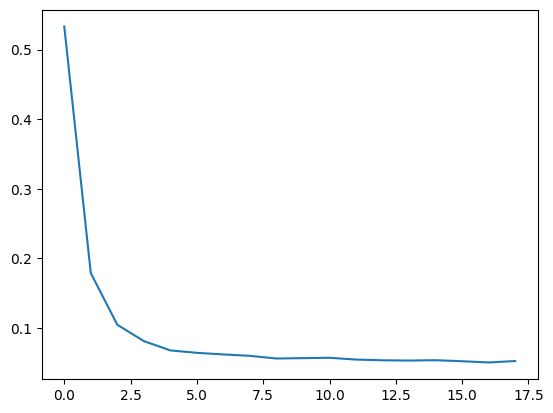

In [13]:
plt.figure()
plt.plot(all_losses_list)
plt.show()

In [14]:
# Example usage after model training
user_id_to_recommend = 22  # Specify the user for whom you want recommendations
user_rated_movies = df_train[df_train['userId'] == user_id_to_recommend]['movieId'].tolist()

model.eval()  # Set the model to evaluation mode
recommended_movies_info = model.recommend_movies(user_id_to_recommend, user_rated_movies, movies_df)
print(f"Top recommendations for user {user_id_to_recommend}:")
for movie_info in recommended_movies_info:
    print(movie_info)

Top recommendations for user 22:
{'MovieID': 7367, 'Title': 'Ladykillers, The (2004)', 'Genres': 'Comedy|Crime'}
{'MovieID': 840, 'Title': 'House Arrest (1996)', 'Genres': 'Children|Comedy'}
{'MovieID': 277, 'Title': 'Miracle on 34th Street (1994)', 'Genres': 'Drama'}
{'MovieID': 2589, 'Title': 'Friends & Lovers (1999)', 'Genres': 'Comedy|Drama|Romance'}
{'MovieID': 898, 'Title': 'Philadelphia Story, The (1940)', 'Genres': 'Comedy|Drama|Romance'}
{'MovieID': 1092, 'Title': 'Basic Instinct (1992)', 'Genres': 'Crime|Mystery|Thriller'}
{'MovieID': 5532, 'Title': "Amy's O (a.k.a. Amy's Orgasm) (2001)", 'Genres': 'Comedy|Romance'}
{'MovieID': 5582, 'Title': 'Captain Ron (1992)', 'Genres': 'Adventure|Comedy'}
{'MovieID': 2144, 'Title': 'Sixteen Candles (1984)', 'Genres': 'Comedy|Romance'}
{'MovieID': 224, 'Title': 'Don Juan DeMarco (1995)', 'Genres': 'Comedy|Drama|Romance'}
{'MovieID': 1733, 'Title': 'Afterglow (1997)', 'Genres': 'Drama|Romance'}
{'MovieID': 510, 'Title': 'Poetic Justice (19

In [15]:
model1=ImprovedRecSysModel(
    n_users=len(lbl_user.classes_),
    n_movies=len(lbl_movie.classes_),
).to(device)

optimizer1=torch.optim.Adam(model1.parameters())
sch1=torch.optim.lr_scheduler.StepLR(optimizer1,step_size=3,gamma=0.7)

loss_func1=nn.MSELoss()

# Deeper Neural network

In [16]:
epoch1 = 1
total_loss1 = 0
plot_steps1, print_steps1 = 5000, 5000
step_cnt1 = 0
all_losses_list1 = []

model1.train()
for epochh1 in range(epoch1):
    for i, train_data1 in enumerate(train_loader):
        output1 = model1(train_data1['users'], train_data1['movies'])

        rating1 = train_data1['ratings'].view(4, -1).to(torch.float32)

        loss1 = loss_func1(output1, rating1)
        total_loss1 = total_loss1 + loss1.sum().item()
        optimizer1.zero_grad()
        loss1.backward()
        optimizer1.step()
        

        step_cnt1 = step_cnt1 + len(train_data1['users'])

        if step_cnt1 % plot_steps1 == 0:
            avg_loss1 = total_loss1 / (len(train_data1['users']) * plot_steps1)
            print(f"epoch:{epochh1} loss at step: {step_cnt1} is {avg_loss1}")
            all_losses_list1.append(avg_loss1)
            total_loss1 = 0
        

epoch:0 loss at step: 5000 is 0.15844450107682495
epoch:0 loss at step: 10000 is 0.09516093517290428
epoch:0 loss at step: 15000 is 0.08893796778898687
epoch:0 loss at step: 20000 is 0.08063193366937339
epoch:0 loss at step: 25000 is 0.07682667211405933
epoch:0 loss at step: 30000 is 0.07470579281607642
epoch:0 loss at step: 35000 is 0.07301321536609903
epoch:0 loss at step: 40000 is 0.06948775429758243
epoch:0 loss at step: 45000 is 0.06864471593955532
epoch:0 loss at step: 50000 is 0.06810195428924636
epoch:0 loss at step: 55000 is 0.07005200695926324
epoch:0 loss at step: 60000 is 0.06565166093166917
epoch:0 loss at step: 65000 is 0.06628102525938302
epoch:0 loss at step: 70000 is 0.06642490299036727
epoch:0 loss at step: 75000 is 0.066512492156215
epoch:0 loss at step: 80000 is 0.06566971540236846
epoch:0 loss at step: 85000 is 0.06437583309221082
epoch:0 loss at step: 90000 is 0.06306112673860043


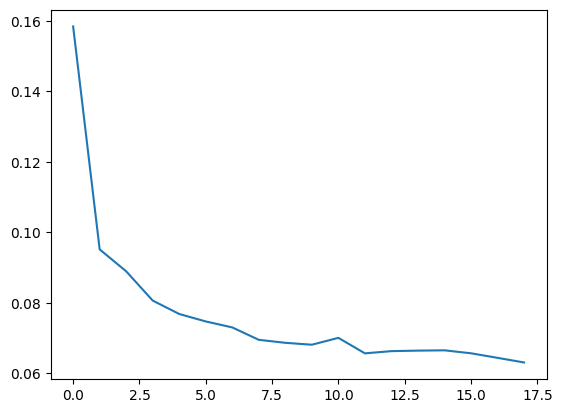

In [17]:
plt.figure()
plt.plot(all_losses_list1)
plt.show()

In [18]:
# Example usage after model training
user_id_to_recommend = 22  # Specify the user for whom you want recommendations
user_rated_movies = df_train[df_train['userId'] == user_id_to_recommend]['movieId'].tolist()

model1.eval()  # Set the model to evaluation mode
recommended_movies_info = model1.recommend_movies(user_id_to_recommend, user_rated_movies, movies_df)
print(f"Top recommendations for user {user_id_to_recommend}:")
for movie_info in recommended_movies_info:
    print(movie_info)

Top recommendations for user 22:
{'MovieID': 731, 'Title': "Heaven's Prisoners (1996)", 'Genres': 'Crime|Thriller'}
{'MovieID': 2881, 'Title': 'Double Jeopardy (1999)', 'Genres': 'Action|Crime|Drama|Thriller'}
{'MovieID': 6323, 'Title': 'Identity (2003)', 'Genres': 'Crime|Horror|Mystery|Thriller'}
{'MovieID': 7327, 'Title': 'Persona (1966)', 'Genres': 'Drama'}
{'MovieID': 840, 'Title': 'House Arrest (1996)', 'Genres': 'Children|Comedy'}
{'MovieID': 1228, 'Title': 'Raging Bull (1980)', 'Genres': 'Drama'}
{'MovieID': 2655, 'Title': 'Howling II: Your Sister Is a Werewolf (1985)', 'Genres': 'Horror'}
{'MovieID': 5450, 'Title': 'Lovely & Amazing (2001)', 'Genres': 'Comedy|Drama|Romance'}
{'MovieID': 8019, 'Title': 'Dark Water (Honogurai mizu no soko kara) (2002)', 'Genres': 'Drama|Horror|Mystery|Thriller'}
{'MovieID': 3324, 'Title': 'Drowning Mona (2000)', 'Genres': 'Comedy'}
{'MovieID': 485, 'Title': 'Last Action Hero (1993)', 'Genres': 'Action|Adventure|Comedy|Fantasy'}
{'MovieID': 4187, 